In [12]:
#tp_cars 
#Attention, le programme met du temps à tourner

import pandas as pd
import random as rd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import balanced_accuracy_score, plot_confusion_matrix, accuracy_score, recall_score,precision_score,f1_score,classification_report
from sklearn import preprocessing as pp
from sklearn.metrics import roc_curve, auc
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [13]:
Files = ['audi.csv','bmw.csv','cclass.csv','focus.csv','ford.csv','hyundi.csv',
         'merc.csv','skoda.csv','toyota.csv','vauxhall.csv','vw.csv']
!pwd

/home/theophile.baggio/RNN/cars


In [14]:
cpt = 0
for file in Files:
    
    if cpt == 0:
        df = pd.read_csv(file)
        df['marque'] = [file[:-4]]*len(df)
    else:
        table = pd.read_csv(file)
        if 'tax(£)' in table.columns:
            table.rename(columns={'tax(£)': 'tax'}, inplace=True)
        table['marque'] = [file[:-4]]*len(table)
        df = pd.concat([df,table])
    cpt = cpt + 1
    

In [15]:
for i in ['model', 'transmission', 'fuelType', 'marque']:
    df[i] = pp.LabelEncoder().fit_transform(df[i])
#normalize our traindata
traindata = df.drop('price',axis=1)
scaler = StandardScaler()
scaler.fit(traindata)
traindata = scaler.transform(traindata)
df.loc[:, df.columns != 'price'] = traindata


In [16]:
xtax = np.array(df[~df.tax.isnull()].drop(['tax','mpg'], axis = 1))
xmpg = np.array(df[~df.mpg.isnull()].drop(['tax','mpg'], axis = 1))
ytax = np.array(df[~df.tax.isnull()].tax)
ympg = np.array(df[~df.mpg.isnull()].mpg)

In [17]:
modeltax = LinearRegression().fit(xtax, ytax)
modelmpg = LinearRegression().fit(xmpg,ympg)
#print(modeltax.score(xtax,ytax), modelmpg.score(xmpg,ympg)) 
#que represente le score coefficeint de determination?

Si le R² vaut 1, cela signifie que l’équation de la droite de régression est capable de déterminer 100 % de la distribution des points. Cela signifie alors que le modèle mathématique utilisé, ainsi que les paramètres a et b calculés sont ceux qui déterminent la distribution des points. En bref, plus le coefficient de détermination se rapproche de 0, plus le nuage de points se disperse autour de la droite de régression. Au contraire, plus le R² tend vers 1, plus le nuage de points se resserre autour de la droite de régression. Quand les points sont exactement alignés sur la droite de régression, alors R² = 1.

In [18]:
#on remplace les NA grace à une régression linéaire dans les colonnes tax et mpg
taxnul = list(np.where(df['tax'].isnull())[0])
mpgnul = list(np.where(df['mpg'].isnull())[0])
xtemp = np.array(df[df.tax.isnull()].drop(['tax','mpg'], axis = 1))
ytemp = modeltax.predict(xtemp)
df['tax'].iloc[taxnul] = ytemp
xtemp1 = np.array(df[df.mpg.isnull()].drop(['tax','mpg'], axis = 1))
ytemp1 = modelmpg.predict(xtemp1)
df['mpg'].iloc[mpgnul] = ytemp1

/usr/local/lib64/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib64/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
#production modèle MLPRegressor
# On génère des modèles 1 couche cachée je fais des tests pour choisir le modèle plus efficace en utilisant
#la cross validation:
#nbmodel = 35;
#Model = [];
#Name=[];
#for i in range(30,nbmodel):
#    Model.append(MLPRegressor(solver='lbfgs', alpha=1e-8, max_iter = 1e7, hidden_layer_sizes=(i+1)))
#    Name.append("Model"+str(i+1))

#cross-validation
#nsplits=5
#results = []
#for i in range(30,nbmodel):
#    kfold = StratifiedKFold(n_splits=nsplits, random_state=1, shuffle=True)
#    cv_results = cross_val_score(Model[i-30], df.drop('price',axis=1), df['price'], cv=kfold, scoring='r2')
#    results.append(cv_results)
#    print('%s: %f (%f)' % (Name[i-30], cv_results.mean(), cv_results.std()))

#le programme met du temps à tourner, j'ai choisi nombre neurones = 35 pour mon model

In [20]:
nbneurons = 35
model = MLPRegressor(solver='lbfgs', alpha=1e-8, max_iter = 1e7, hidden_layer_sizes=(nbneurons))
model.fit(df.drop('price',axis=1), df['price'])
kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
cv_results = cross_val_score(model, df.drop('price',axis=1), df['price'], cv=kfold, scoring='r2')
print('Score R2 de mon modele: {}'.format(np.mean(cv_results)))

/usr/local/lib64/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Score R2 de mon modele: [0.88051639 0.90377682 0.89882741 0.88249048 0.88686953]


In [21]:
yest = np.array(model.predict(df.drop('price',axis=1)))
yexact = np.array(df['price'])
score = (np.linalg.norm(yest-yexact,2))**2
print("Le score sous forme (yest-yexact)^2 est: {:.3e}.\
Pas très indicatif ^^ \n\nJe n'ai pas bien vu l'intérêt du leave one out avec autant d'échantillons,\
\nc'est d'ailleurs écrit dans la documentation: \
'Due to the high number of test sets (which is the same as the number of samples)\
this cross-validation method can be very costly.\
For large datasets one should favor \nKFold, ShuffleSplit or StratifiedKFold.'\n J'ai donc pris le\
 parti d'utiliser seulement le stratifiedKfold sachant que le résultat obtenu n'était pas vrt amélioré\
 avec le Leave one out".format(score))

Le score sous forme (yest-yexact)^2 est: 9.725e+11.Pas très indicatif ^^ 

Je n'ai pas bien vu l'intérêt du leave one out avec autant d'échantillons,
c'est d'ailleurs écrit dans la documentation: 'Due to the high number of test sets (which is the same as the number of samples)this cross-validation method can be very costly.For large datasets one should favor 
KFold, ShuffleSplit or StratifiedKFold.'
 J'ai donc pris le parti d'utiliser seulement le stratifiedKfold sachant que le résultat obtenu n'était pas vrt amélioré avec le Leave one out


<function matplotlib.pyplot.show(close=None, block=None)>

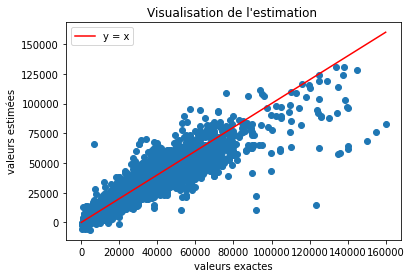

In [22]:
x = np.linspace(0, 160000, 2)
plt.scatter(yexact, yest)
plt.plot(x,x,'r',label="y = x")
plt.xlabel("valeurs exactes")
plt.ylabel("valeurs estimées")
plt.title("Visualisation de l'estimation ")
plt.legend()
plt.show

0.8904961251168837